# Configurations

In [1]:
import sys
sys.path.append('..')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sfp_nsdsyn import *
import warnings
import itertools
import matplotlib as mpl

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None
%load_ext autoreload
%autoreload 2

rc = {'text.color': 'black',
      'axes.labelcolor': 'black',
      'xtick.color': 'black',
      'ytick.color': 'black',
      'axes.edgecolor': 'black',
      'font.family': 'Helvetica',
      'figure.dpi': 72 * 2,
      'savefig.dpi': 72 * 4
      }
mpl.rcParams.update(rc)

In [2]:
output_dir='/Volumes/server/Projects/sfp_nsd/derivatives'
fig_dir=os.path.join(output_dir, 'figures/sfp_model/results_1D/nsdsyn')
precision_dir='/Volumes/server/Projects/sfp_nsd/derivatives/dataframes/nsdsyn/precision'

In [4]:
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
roi_list=['V1','V2','V3']
lr = 0.005
max_epoch = 8000
subj_list = [utils.sub_number_to_string(sn, 'nsdsyn') for sn in np.arange(1,9)]
subj='subj02'
voxels='pRFcenter'

# eccentricity bin information
e1, e2=0.5, 4
enum=7
enum_range=range(7) if enum==7 else range(3) 
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
ecc_colors = utils.get_continuous_colors(len(bin_labels)+1, '#3f0377')
ecc_colors = ecc_colors[1:][::-1]
ecc_colors = dict(zip(bin_labels, ecc_colors))

# Load the data and model parameters

In [28]:
f, m = [], []
for subj, roi in itertools.product(subj_list, roi_list):
    file_name = f'e1-{e1}_e2-{e2}_nbin-{enum}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', 'nsdsyn', 'binned', file_name))

subj_df = utils.load_dataframes(f)
subj_df = subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(subj_list, roi_list, enum_range, stim_classes+['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

# Plot tuning curves

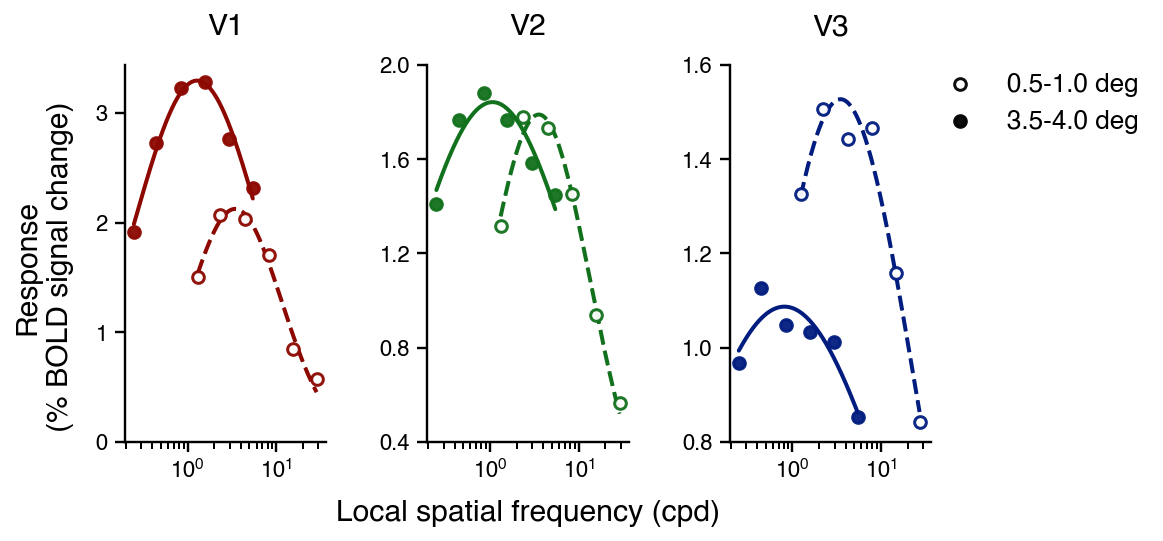

In [29]:
a = [3, 2, 0]
pal = [sns.color_palette('dark', 10)[:][k] for k in a]

bins_to_plot = [bin_labels[k] for k in [0,-1]]
stim_class = 'avg'
tmp_subj_df = subj_df.query('sub == "subj06"')
tmp_tuning_df = tuning_df.query('sub == "subj06" & names == @stim_class')
fig_name = os.path.join(output_dir,"figures", "sfp_model","results_1D", "nsdsyn", f'tuning_class_{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-all_dset-nsdsyn_sub-subj06_roi-all_vs-pRFsize.pdf')
g = vis1D.plot_sf_curves(df=tmp_subj_df, x='local_sf', y='betas', hue='ecc_bin', hue_order=bins_to_plot,
                         col='vroinames', params_df=tmp_tuning_df, lgd_title=None, palette=pal,
                         save_path=None)

# Plot preferred period as function of eccentricity

## Load in precision data

In [30]:
file_list = []
for subj, roi in itertools.product(subj_list, ['V1','V2','V3']):
    f = os.path.join(output_dir, 'dataframes', 'nsdsyn', 'precision', 
                     f'precision-v_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
    
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

## Load in the fitting results and calculate the preferred period

In [31]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(subj_list, roi_list, enum_range, ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-nsdsyn_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'nsdsyn', file_name))
tuning_df = tuning.load_all_models(pt_file_list, *args)

tuning_with_precision_df = tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
tuning_with_precision_df['pp'] = 1/ tuning_with_precision_df['mode']
fit_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

## Plot

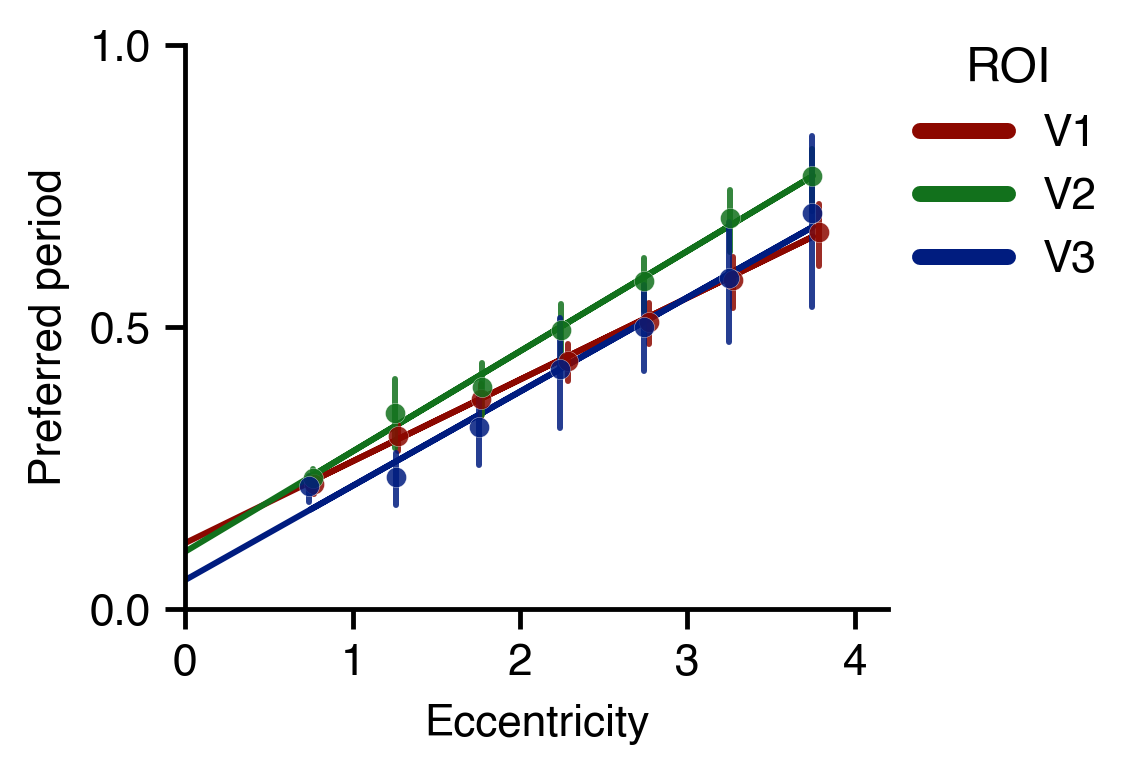

In [32]:
a = [3,2,0]
roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
g = vis1D.plot_preferred_period(tuning_with_precision_df, fit_df=fit_df, 
                                preferred_period='pp', precision='precision', hue='vroinames', 
                                hue_order=['V1','V2','V3'], lgd_title='ROI',
                                pal=roi_pal,
                                save_path=None)

# Plot Bandwidth as function of eccentricity

In [38]:
tuning_with_precision_df['fwhm'] = tuning_with_precision_df['sigma']*2.335
fit_bandwidth_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df, 'fwhm', 'precision', groupby=['vroinames'])

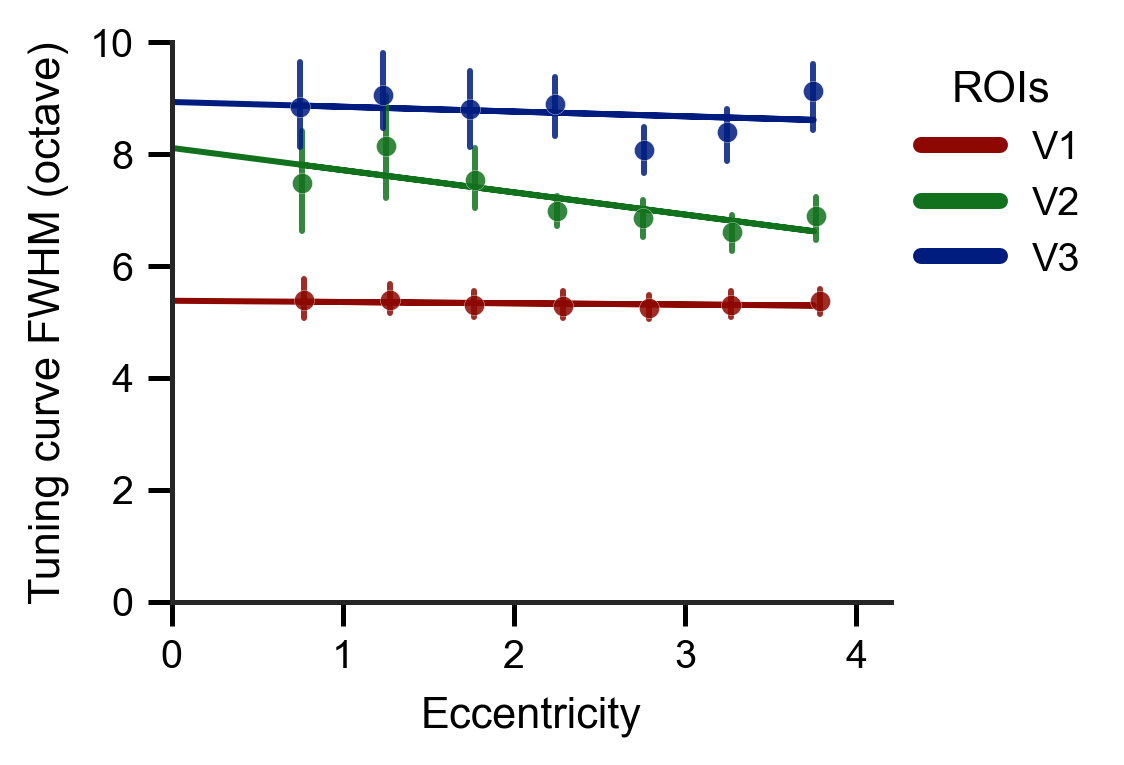

In [62]:
vis1D.plot_bandwidth_in_octave(tuning_with_precision_df, 
                               bandwidth='fwhm', precision='precision', 
                               hue='vroinames', hue_order=roi_list, 
                               fit_df=fit_bandwidth_df,
                               pal=roi_pal,
                               lgd_title='ROIs',
                               col=None, col_order=None,
                               suptitle=None, width=3.25, errorbar=("ci", 68),
                               save_path=None)

## Plot Broderick et al's data together

In [33]:
nsd_tuning_with_precision_df = tuning_with_precision_df
nsd_fit_df = fit_df 

In [5]:
f, m = [], []
dset = 'broderick'
tfunc = 'corrected'
voxels = 'pRFcenter'

broderick_subj_list = [utils.sub_number_to_string(sn, dataset="broderick") for sn in [1, 6, 7, 45, 46, 62, 64, 81, 95, 114, 115, 121]]
e1='1'
e2='12'
enum=11
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)

enum_range=np.arange(0,11)
stim_classes=['annulus', 'pinwheel', 'forward spiral', 'reverse spiral']
lr = 0.005
max_epoch = 8000

In [21]:
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    file_name = f'tfunc-{tfunc}_e1-{e1}_e2-{e2}_nbin-{enum}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{voxels}.csv'
    f.append(os.path.join(output_dir, 'dataframes', dset, 'binned', file_name))

subj_df = utils.load_dataframes(f)
subj_df = subj_df.groupby(['sub','ecc_bin','vroinames','freq_lvl']).mean().reset_index()

args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']

pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(broderick_subj_list, ['V1'], enum_range, stim_classes+['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'tfunc-{tfunc}_model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-{dset}_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', dset, file_name))
    
tuning_df = tuning.load_all_models(pt_file_list, *args)

11

In [33]:
bin_list, bin_labels = tuning.get_bin_labels(e1, e2, enum=enum)
bin_labels[8]

'9.0-10.0 deg'

In [38]:
tmp_tuning_df

,slope,mode,sigma,sub,names,dset,lr_rate,max_epoch,vroinames,e1,e2,nbin,curbin,ecc_bin
0,3.121148,2.556453,3.673786,wlsubj001,annulus,broderick,0.005,8000,V1,1,12,11,0,1.0-2.0 deg
0,3.000999,1.737468,2.953816,wlsubj001,annulus,broderick,0.005,8000,V1,1,12,11,1,2.0-3.0 deg
0,4.446528,1.403385,2.775393,wlsubj001,annulus,broderick,0.005,8000,V1,1,12,11,2,3.0-4.0 deg
0,4.034909,1.138164,2.518188,wlsubj001,annulus,broderick,0.005,8000,V1,1,12,11,3,4.0-5.0 deg
0,4.166498,0.990987,2.332019,wlsubj001,annulus,broderick,0.005,8000,V1,1,12,11,4,5.0-6.0 deg
0,3.937041,0.922373,2.258226,wlsubj001,annulus,broderick,0.005,8000,V1,1,12,11,5,6.0-7.0 deg
0,4.005382,0.836863,2.319199,wlsubj001,annulus,broderick,0.005,8000,V1,1,12,11,6,7.0-8.0 deg
0,3.496680,0.752666,2.094968,wlsubj001,annulus,broderick,0.005,8000,V1,1,12,11,7,8.0-9.0 deg
0,3.101461,0.706906,2.137228,wlsubj001,annulus,broderick,0.005,8000,V1,1,12,11,8,9.0-10.0 deg
0,2.689510,0.666513,2.262052,wlsubj001,annulus,broderick,0.005,8000,V1,1,12,11,9,10.0-11.0 deg


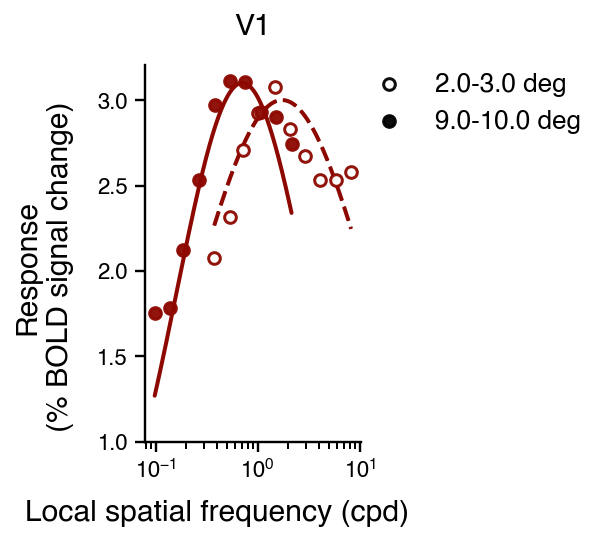

In [35]:

bins_to_plot = [bin_labels[k] for k in [1,8]]
stim_class = 'annulus'
subj = 'wlsubj001'
tmp_subj_df = subj_df.query('sub == @subj & ecc_bin in @bins_to_plot')
tmp_tuning_df = tuning_df.query('sub == @subj & names == @stim_class')
fig_name = os.path.join(output_dir,"figures", "sfp_model","results_1D", dset, f'tuning_class_{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-all_dset-dset_sub-{subj}_roi-all_vs-pRFsize.pdf')
a = [3, 2, 0]
pal = [sns.color_palette('dark', 10)[:][k] for k in a]
g = vis1D.plot_sf_curves_only_for_V1(df=tmp_subj_df, x='local_sf', y='betas',
                         hue='ecc_bin', hue_order=bins_to_plot,
                          col_title='V1', params_df=tmp_tuning_df, lgd_title=None, palette=pal[0],
                         save_path=None)

## Broderick precision data

In [93]:
file_list = []
for subj, roi in itertools.product(broderick_subj_list, ['V1']):
    f = os.path.join(output_dir, 'dataframes', 'broderick', 'precision', 
                     f'precision-v_dset-broderick_sub-{subj}_roi-{roi}_vs-pRFsize.csv')
    file_list.append(f)
    
precision_v = utils.load_dataframes(file_list)
precision_s = precision_v.groupby(['sub','vroinames']).mean().reset_index()
precision_s['precision'] = 1 / precision_s['sigma_v_squared']

In [84]:
precision_s

,sub,vroinames,voxel,noise_SD,sigma_v_squared,precision
0,wlsubj001,V1,1908.200303,0.281490,0.096439,10.369273
1,wlsubj006,V1,1799.843119,0.266244,0.091265,10.957087
2,wlsubj007,V1,1918.370759,0.386783,0.263462,3.795616
3,wlsubj045,V1,2478.168273,0.354677,0.186570,5.359912
4,wlsubj046,V1,2130.788069,0.359892,0.189150,5.286819
5,wlsubj062,V1,2252.353301,0.337320,0.164813,6.067495
6,wlsubj064,V1,2241.684834,0.409408,0.235061,4.254223
7,wlsubj081,V1,2955.924109,0.342377,0.181408,5.512441
8,wlsubj095,V1,1930.140423,0.339045,0.166211,6.016436
9,wlsubj114,V1,2997.682786,0.315322,0.148814,6.719800


In [94]:
args = ['sub', 'class','dset', 'lr', 'eph', 'roi', 'e1', 'e2', 'nbin', 'curbin']
pt_file_list = []
for subj, roi, curbin, stim_class in itertools.product(broderick_subj_list, ['V1'], enum_range, ['avg']):
    stim_class = stim_class.replace(' ', '-')
    file_name = f'tfunc-corrected_model-params_class-{stim_class}_lr-{lr}_eph-{max_epoch}_e1-{e1}_e2-{e2}_nbin-{enum}_curbin-{curbin}_dset-broderick_sub-{subj}_roi-{roi}_vs-{voxels}.pt'
    pt_file_list.append(os.path.join(output_dir, 'sfp_model', 'results_1D', 'broderick', file_name))
tuning_df = tuning.load_all_models(pt_file_list, *args)

broderick_tuning_with_precision_df = tuning_df.merge(precision_s[['sub','vroinames','precision']], on=['sub', 'vroinames'])
broderick_tuning_with_precision_df['pp'] = 1/ broderick_tuning_with_precision_df['mode']
broderick_fit_df = vis1D.fit_line_to_weighted_mean(broderick_tuning_with_precision_df, 'pp', 'precision', groupby=['vroinames'])

In [24]:
bin_labels, tuning.get_bin_labels(1, 12, 11)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]),
 ['1.0-2.0 deg',
  '2.0-3.0 deg',
  '3.0-4.0 deg',
  '4.0-5.0 deg',
  '5.0-6.0 deg',
  '6.0-7.0 deg',
  '7.0-8.0 deg',
  '8.0-9.0 deg',
  '9.0-10.0 deg',
  '10.0-11.0 deg',
  '11.0-12.0 deg'])

In [90]:
broderick_tuning_with_precision_df['dset_type'] = 'Broderick et al. V1'
broderick_fit_df['dset_type'] = 'Broderick et al. V1'
nsd_tuning_with_precision_df['dset_type'] = nsd_tuning_with_precision_df['vroinames'].apply(lambda x: f'NSD {x}')
nsd_fit_df['dset_type'] = nsd_fit_df['vroinames'].apply(lambda x: f'NSD {x}')

In [91]:
tuning_with_precision_df = pd.concat((broderick_tuning_with_precision_df, nsd_tuning_with_precision_df), axis=0)
fit_df = pd.concat((broderick_fit_df, nsd_fit_df), axis=0)

In [49]:
roi_pal

[(0.5490196078431373, 0.03137254901960784, 0.0),
 (0.07058823529411765, 0.44313725490196076, 0.10980392156862745),
 (0.0, 0.10980392156862745, 0.4980392156862745)]

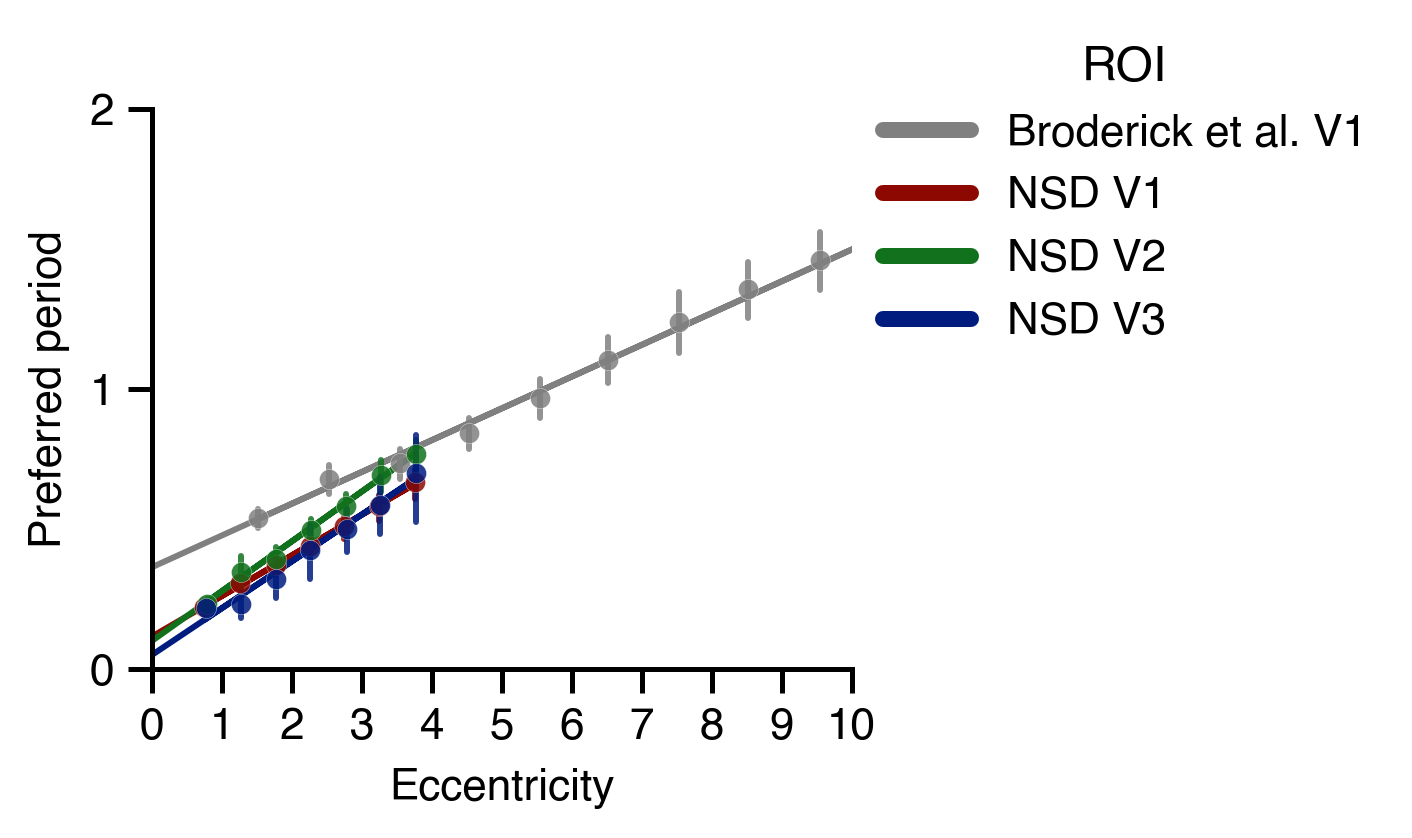

In [102]:
a = [3,2,0]

roi_pal = [sns.color_palette('dark', 10)[:][k] for k in a]
roi_pal.insert(0, (0.5,0.5,0.5))
g = vis1D.plot_preferred_period(tuning_with_precision_df, fit_df=fit_df, 
                                preferred_period='pp', precision='precision', hue='dset_type', 
                                hue_order=['Broderick et al. V1',
                                           'NSD V1', 'NSD V2','NSD V3'], lgd_title='ROI',
                                pal=roi_pal,
                                save_path=None)

In [96]:
tuning_with_precision_df['fwhm'] = tuning_with_precision_df['sigma'] * 2.335 
fit_bandwidth_df = vis1D.fit_line_to_weighted_mean(tuning_with_precision_df,'fwhm','precision',groupby=['vroinames','dset_type'])


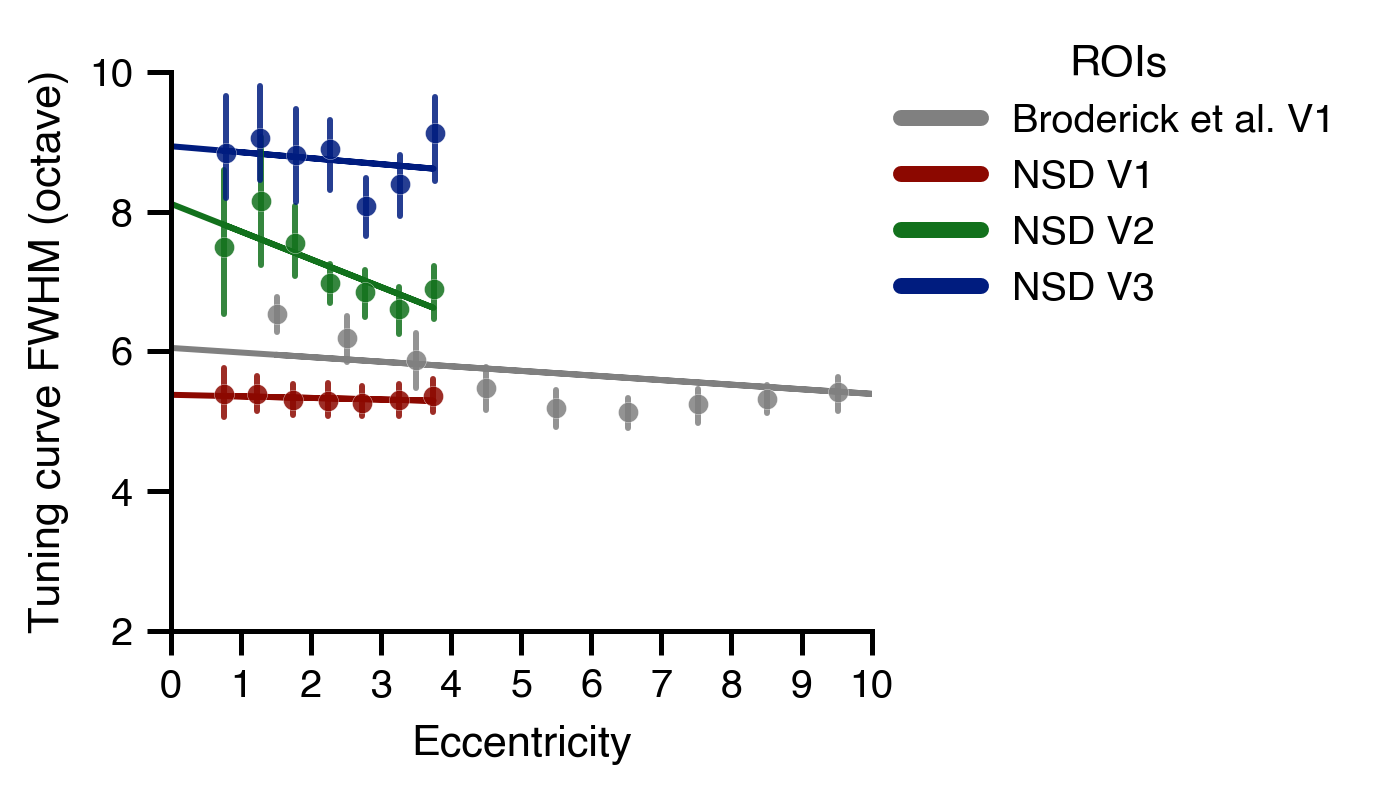

In [101]:
vis1D.plot_bandwidth_in_octave(tuning_with_precision_df, 
                               bandwidth='fwhm', precision='precision', 
                               hue='dset_type', hue_order=['Broderick et al. V1',
                                           'NSD V1', 'NSD V2','NSD V3'], 
                               fit_df=fit_bandwidth_df,
                               pal=roi_pal,
                               lgd_title='ROIs',
                               col=None, col_order=None,
                               suptitle=None, width=3.25, errorbar=("ci", 68),
                               save_path=None)